<a href="https://colab.research.google.com/github/Anmolsharma425/Emotion_classification/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ./kaggle

In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 81% 49.0M/60.3M [00:00<00:00, 98.9MB/s]
100% 60.3M/60.3M [00:00<00:00, 103MB/s] 


In [3]:
!unzip -q /content/fer2013.zip -d /content/kaggle

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
    CSVLogger
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense,
    Activation
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model


In [5]:
project_name = "Emotion_detection"

model_name = [
    'Custom_CNN from scratch',
    'Custom_CNN with Augmentation',
    'VGG16',
    'ResNet50_Transfer_learning'
]

base_dir = '/content/kaggle'
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok = True)

# Create subdirectory in base folder
for model in model_name:
  model_dir = os.path.join(project_dir, model)
  os.makedirs(model_dir, exist_ok = True)


# Data Cleaning

In [6]:
img_ext = ['jpeg', 'jpg', 'png']

data_dir = '/content/kaggle/train'

for root, dirs, files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root, file)

    try:
      file_ext = imghdr.what(file_path)
      if file_ext not in img_ext:
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)
    except Exception as e:
      print(f"Error: {e}")
      os.remove(file_path)

In [7]:
def count_files_in_folder(directory, set_name):
  counts = {}

  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)

    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))
    df = pd.DataFrame(counts, index = [set_name])

  return df


In [8]:
train_dir = '/content/kaggle/train'
test_dir = '/content/kaggle/test'

train_count = count_files_in_folder(train_dir, 'train')
test_count = count_files_in_folder(test_dir, 'test')

print(train_count)
print(test_count)

        sad  angry  surprise  happy  disgust  neutral  fear
train  4830   3995      3171   7215      436     4965  4097
       sad  angry  surprise  happy  disgust  neutral  fear
test  1247    958       831   1774      111     1233  1024


<Figure size 1000x700 with 0 Axes>

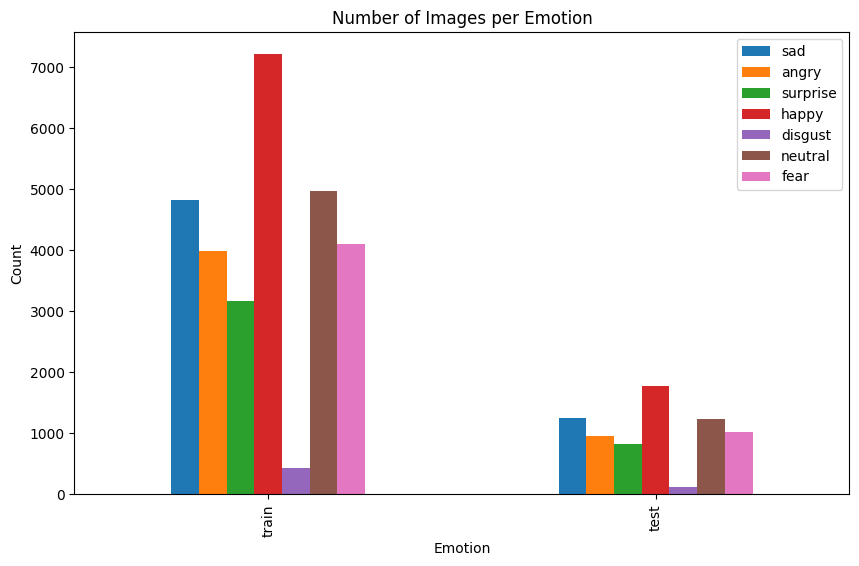

In [9]:
combined_df = pd.concat([train_count, test_count])
plt.figure(figsize = (10, 7))

combined_df.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Images per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


# Image Plot

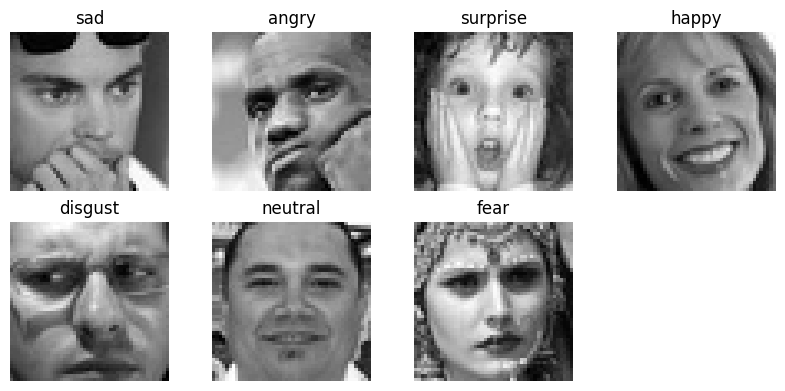

In [10]:
emotion_labels = os.listdir(train_dir)
plt.figure(figsize = (10, 7))

for i, emotion in enumerate(emotion_labels, 1):
  folder = os.path.join(train_dir, emotion)
  img_path = os.path.join(folder, os.listdir(folder)[12])
  img = plt.imread(img_path)
  plt.subplot(3, 4, i)
  plt.imshow(img, cmap = 'gray')
  plt.title(emotion)
  plt.axis('off')

In [11]:
def plot_image_from_directory(directory_path, class_name, num_images = 9):
  image_filename = os.listdir(directory_path)
  if len(image_filename) < num_images:
    print(f"Directory {directory_path} does not contain enough images.")
    num_images = len(image_filename)
  selected_images = random.sample(image_filename, num_images)

  fig, axes = plt.subplots(3, 3, figsize = (10, 7))
  axes = axes.ravel()
  for i, image_name in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_name)
    image = load_img(image_path)
    axes[i].imshow(image)
    axes[i].set_title(class_name)
    axes[i].axis('off')
  plt.tight_layout
  plt.show()

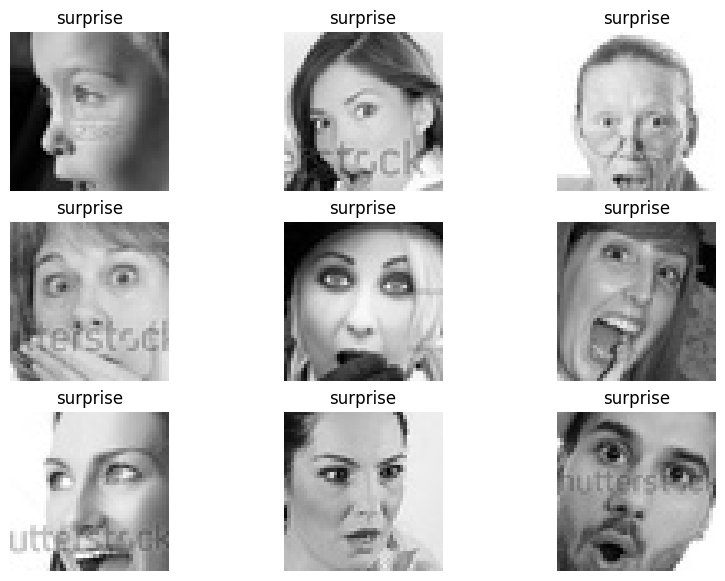

In [12]:
plot_image_from_directory('/content/kaggle/train/surprise', 'surprise')

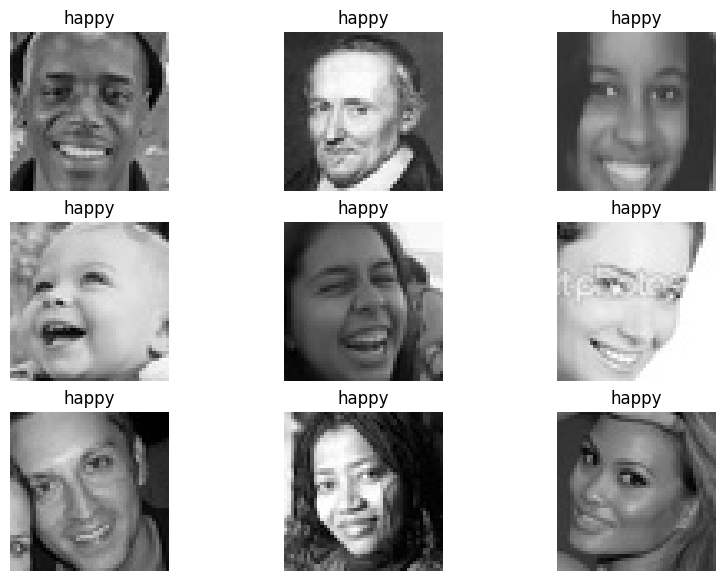

In [13]:
plot_image_from_directory('/content/kaggle/train/happy', 'happy')

In [14]:
image = '/content/kaggle/train/fear/Training_10018621.jpg'
image = cv2.imread(image)
if image is not None:
  print("Image_shape:", image.shape)
else:
  print("Fail to load the image")

Image_shape: (48, 48, 3)


In [15]:
image = '/content/kaggle/train/fear/Training_10018621.jpg'
image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
if image is not None:
  print("Image_shape:", image.shape)
else:
  print("Fail to load the image")

Image_shape: (48, 48)


# Model_1 : Custom CNN from scratch

In [16]:
train_dir = '/content/kaggle/train'
test_dir = '/content/kaggle/test'

img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [17]:
data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
train_class_labels = train_generator.class_indices
validation_class_labels = validation_generator.class_indices
test_class_labels = test_generator.class_indices

print("Train_class_labels: ", train_class_labels)
print("Validation_class_labels: ", validation_class_labels)
print("Test_class_labels: ", test_class_labels)

Train_class_labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation_class_labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test_class_labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [19]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), kernel_initializer="glorot_uniform", padding = 'same', input_shape = (img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size= (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
    metrics = ['accuracy']
)

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │              

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

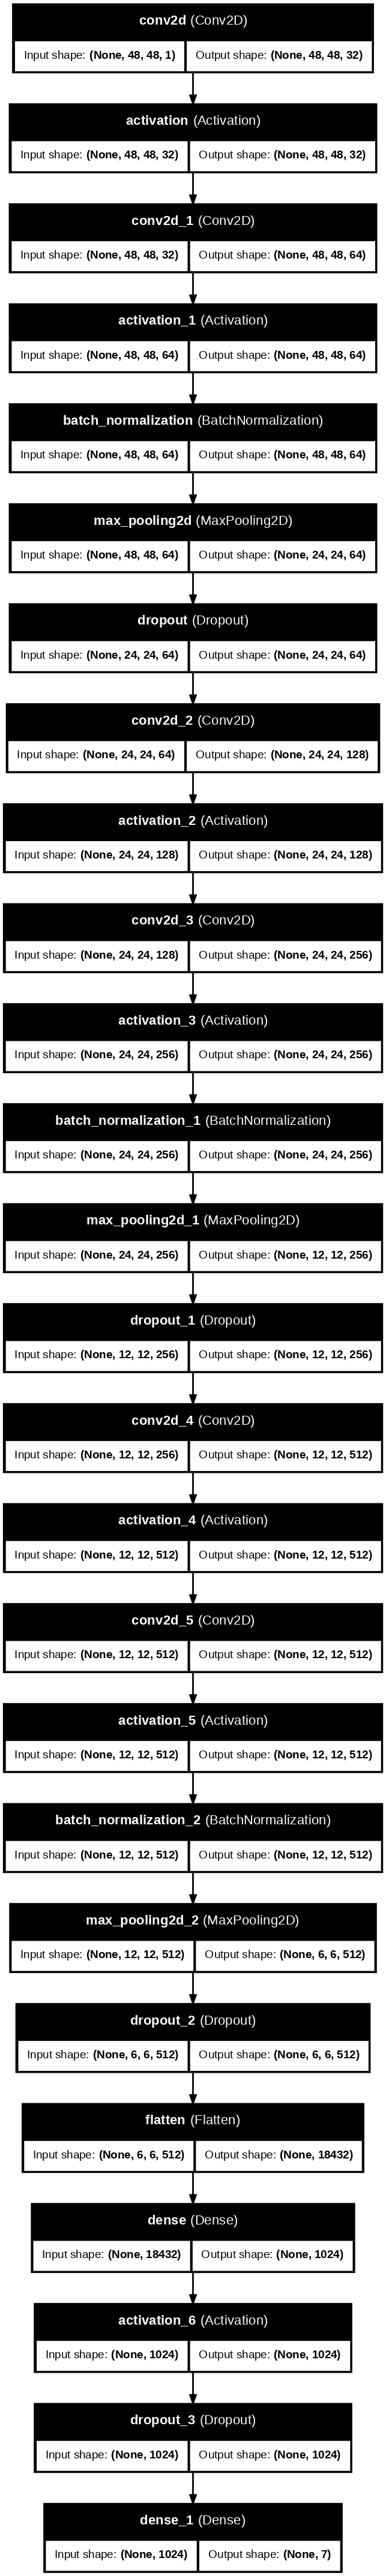

In [22]:
plot_model(model, to_file = '/content/kaggle/Emotion_detection/Custom_CNN from scratch/Architecture.png',
           show_shapes=True,  show_layer_names=True, dpi=100)

In [23]:
checkpoint = ModelCheckpoint(
    filepath = '/content/kaggle/Emotion_detection/Custom_CNN from scratch/model.keras',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min'
)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3,
    verbose = 1,
    min_delta = 0.0001
)

In [24]:
cnn_path = '/content/kaggle/Emotion_detection/Custom_CNN from scratch/'
csv_logger = CSVLogger(
    os.path.join(cnn_path, 'training.log')
)

callbacks = [checkpoint, early_stopping, reduce_lr, csv_logger]

In [25]:
train_steps = train_generator.samples // train_generator.batch_size + 1
validation_steps = validation_generator.samples // validation_generator.batch_size + 1
test_steps = test_generator.samples // test_generator.batch_size + 1

In [26]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    callbacks = callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2430 - loss: 13.3240
Epoch 1: val_loss improved from inf to 14.51573, saving model to /content/kaggle/Emotion_detection/Custom_CNN from scratch/model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.2430 - loss: 13.3214 - val_accuracy: 0.1427 - val_loss: 14.5157 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3315 - loss: 10.5448
Epoch 2: val_loss improved from 14.51573 to 9.19103, saving model to /content/kaggle/Emotion_detection/Custom_CNN from scratch/model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - accuracy: 0.3315 - loss: 10.5432 - val_accuracy: 0.3843 - val_loss: 9.1910 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3788 - loss: 8.3396
Epoch 3: val_loss improved from 9.19103 to 6.90105, saving model to /content/kaggle/Emotion_detection/Custom_CNN from scratch/model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/

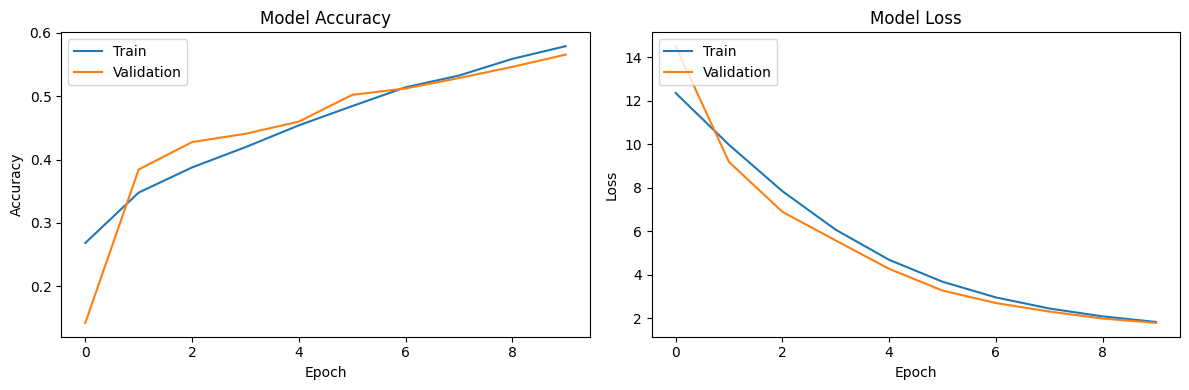

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step


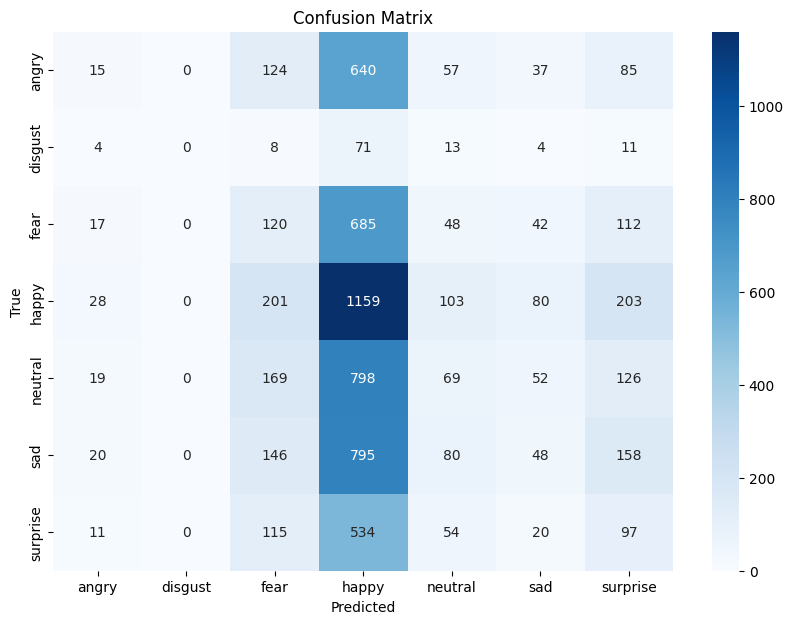

In [46]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.14      0.11      0.12       958
     disgust       0.03      0.01      0.01       111
        fear       0.12      0.07      0.09      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.16      0.14      0.15      1233
         sad       0.18      0.26      0.21      1247
    surprise       0.14      0.14      0.14       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.17      0.18      0.18      7178



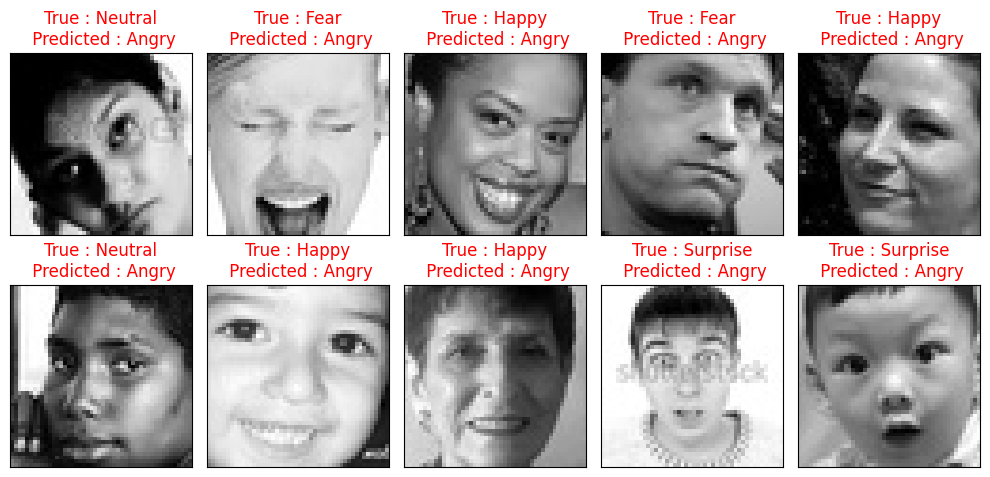

In [31]:
Emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size
Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 5), subplot_kw = {'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
  Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis = 0)
  Model_prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis = 0), verbose = 0), axis = 0)[0]

  ax.imshow(Random_Img.squeeze(), cmap = 'gray')
  color = 'green' if Random_Img_Label == Model_prediction else 'red'
  ax.set_title(f"True : {Emotion_classes[Random_Img_Label]}\n Predicted : {Emotion_classes[Model_prediction]}", color = color)

plt.tight_layout()
plt.show()

# Custom_CNN with Augmentation

In [32]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

test_data_generator = ImageDataGenerator(rescale = 1./255)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


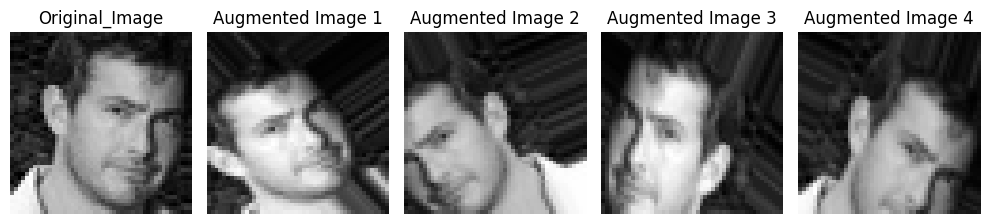

In [33]:
image_path = '/content/kaggle/train/angry/Training_10120469.jpg'

img = load_img(image_path, color_mode = 'grayscale', target_size = (img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 7))

axes[0].imshow(img_array[0, :, :, 0], cmap = 'gray')
axes[0].set_title('Original_Image')
axes[0].axis('off')

for i, ax in enumerate(axes.flat[1: ]):
  aug_iter = data_generator.flow(img_array, batch_size = 1)
  aug_img = next(aug_iter)[0]
  ax.imshow(aug_img, cmap = 'gray')
  ax.set_title(f'Augmented Image {i + 1}')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), kernel_initializer="glorot_uniform", padding = 'same', input_shape = (img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size= (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
    metrics = ['accuracy']
)

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 512)           │              

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

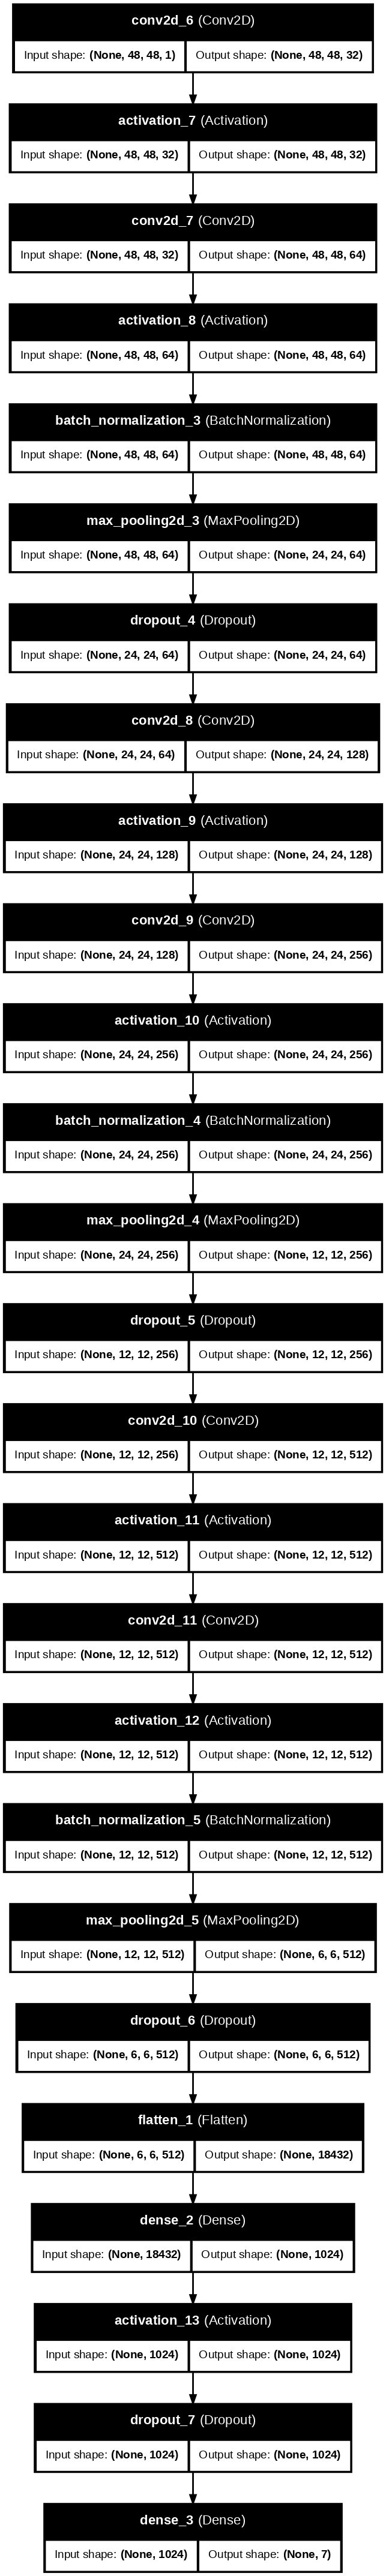

In [39]:
plot_model(model, to_file = '/content/kaggle/Emotion_detection/Custom_CNN with Augmentation/Architecture.png',
           show_shapes=True,  show_layer_names=True, dpi=100)

In [42]:
checkpoint = ModelCheckpoint(
    filepath = '/content/kaggle/Emotion_detection/Custom_CNN with Augmentation/model.keras',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min'
)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3,
    verbose = 1,
    min_delta = 0.0001
)

In [44]:
cnn_path = '/content/kaggle/Emotion_detection/Custom_CNN with Augmentation'
csv_logger = CSVLogger(
    os.path.join(cnn_path, 'training.log')
)

callbacks = [checkpoint, early_stopping, reduce_lr, csv_logger]

In [45]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    callbacks = callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2084 - loss: 13.4912
Epoch 1: val_loss improved from inf to 13.99653, saving model to /content/kaggle/Emotion_detection/Custom_CNN with Augmentation/model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.2085 - loss: 13.4884 - val_accuracy: 0.1874 - val_loss: 13.9965 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2372 - loss: 10.7111
Epoch 2: val_loss improved from 13.99653 to 9.77570, saving model to /content/kaggle/Emotion_detection/Custom_CNN with Augmentation/model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.2372 - loss: 10.7095 - val_accuracy: 0.2482 - val_loss: 9.7757 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2464 - loss: 8.4769
Epoch 3: val_loss improved from 9.77570 to 7.23757, saving model to /content/kaggle/Emotion_detection/Custom_CNN with Augmentation/model.keras
359/359 ━━━━━━━━━━━━━━━

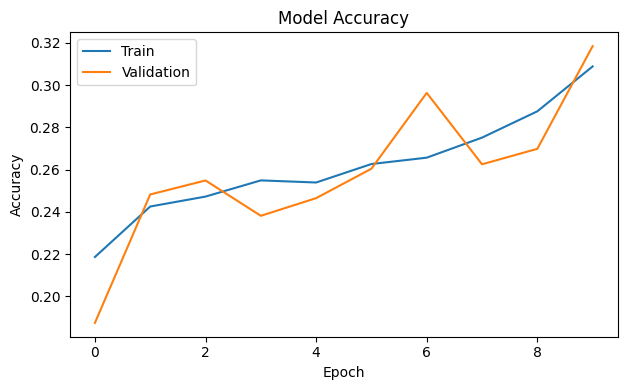

In [47]:
def plot_accuracy(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

plot_accuracy(history)

In [48]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.3173 - loss: 1.9762
Train Loss: 1.9763, Train Accuracy: 0.3181
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.3194 - loss: 1.9667
Test Loss: 1.9781, Test Accuracy: 0.3123


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step


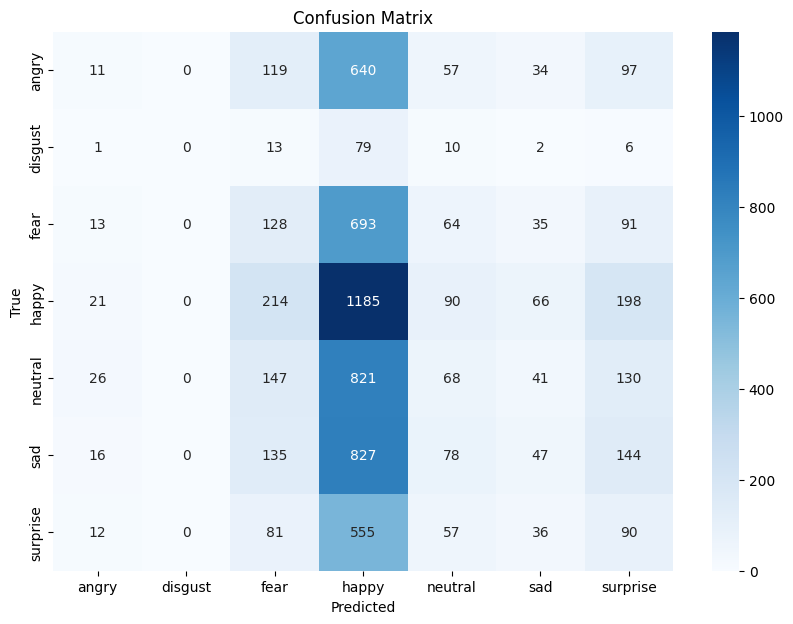

In [49]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()